In [ ]:
%matplotlib inline

### Database MNIST usando Keras

Vamos trabalhar agora com um dataset de imagens muito conhecido, chamado MNIST. Esse dataset possui imagens de números separados em 10 classes (de 0 a 9).

In [1]:
import numpy as np
from random import shuffle, seed
seed(42)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import optimizers

Using TensorFlow backend.


Vamos carregar nosso dataset e verificar qual as dimensões dos dados.

In [2]:
mnist_classes = 10

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

print("\nX_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

11493376/11490434 [==============================] - 12s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)

X_test original shape (10000, 28, 28)
y_test original shape (10000,)


Neste exemplo, iremos dividir o dataset de treinamento em 2 partes: um dataset maior, que continuará sendo usado para treinamento e outro menor que será usado para validação antes do teste. Vamos entender melhor essa abordagem mais a frente.

In [3]:
# 80% para treino e 20% para validação
nData = X_train.shape[0]
nTrain = int(nData * 0.8)

randomIdx = list(range(nData))   #randomly select indexes
shuffle(randomIdx)
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Split the data
X_val, y_val = X_train[valIdx], y_train[valIdx]
X_train, y_train = X_train[trainIdx], y_train[trainIdx]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)

X_train shape (48000, 28, 28)
y_train shape (48000,)
X_val shape (12000, 28, 28)
y_val shape (12000,)


Vamos dar uma olhada em alguns exemplos do nosso dataset de treinamento:

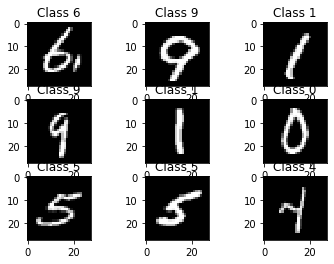

In [4]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Vamos checar também o balanceamento do nosso dataset, ou seja, quantos exemplos nós temos de cada classe? Datasets desbalanceados podem gerar problemas durante o treinamento do modelo. Nesses casos, alguma medida deve ser tomada, como calcular pesos para cada classe, gerar mais exemplos de classes com poucos exemplos, entre outras.

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
print ("Train ---> ", dict(zip(unique, counts)), "\n")

unique, counts = np.unique(y_test, return_counts=True)
print("Test ---> ", dict(zip(unique, counts)), "\n")

Train --->  {0: 4724, 1: 5393, 2: 4723, 3: 4881, 4: 4704, 5: 4313, 6: 4769, 7: 5001, 8: 4730, 9: 4762} 

Test --->  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009} 



Vamos formatar os dados para o treinamento para que cada imagem 28x28 seja um vetor de dimensão 784. Vamos também mudar o range dos dados de entrada de [0-255] para [0-1]. Além disso, nosso vetor y será modificado para que cada classe represente uma coluna.

In [6]:
# reshape images
X_train = X_train.reshape(48000, 784)
X_val = X_val.reshape(12000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

print("X_train matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("X_test matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, mnist_classes)
Y_val = np_utils.to_categorical(y_val, mnist_classes)
Y_test = np_utils.to_categorical(y_test, mnist_classes)

print("\ny_train matrix shape", Y_train.shape)
print("y_train matrix shape", Y_val.shape)
print("y_test matrix shape", Y_test.shape)

X_train matrix shape (48000, 784)
Validation matrix shape (12000, 784)
X_test matrix shape (10000, 784)

y_train matrix shape (48000, 10)
y_train matrix shape (12000, 10)
y_test matrix shape (10000, 10)


### Construindo a rede neural

Vamos agora construir nossa rede neural para treinamento. Utilizaremos nesse exemplo uma rede com 3 camadas completamente conectadas (neste tipo de camada, cada nó é conectado a todos os dados de entrada, ou pixels):
- 1 camada de entrada com 512 nós, com ativação 'relu' e dropout de 0.2
- 1 camada escondida com 512 nós, ativação 'relu' e dropout de 0.2
- 1 camada de saída com ativação 'softmax'



In [7]:
# create the model

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
                           
model.add(Dropout(0.2))   
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

Vamos agora compilar nosso modelo. Keras pede para que você especifique pelo menos 2 parâmetros: **loss function** (função de perda) e o **optimizer** (otimizador).

Vamos utilizar nesse caso a função de perda *categorical_crossentropy*, utilizada para comparar duas distribuições de probabilidades. Por exemplo, o objetivo do nosso modelo é calcular uma distribuição de probabilidade de 100% para a classe correta e 0% para todas as outras. A cross_entropy calcula a diferença entre a distribuição ideal e a calculada pelo nosso modelo. Você pode ler mais sobre isso no [Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy).

O otimizador ajuda o modelo a determinar quão rápido o modelo aprende, ou o quanto ele é resistente a travamentos. Não entraremos em muitos detalhes aqui, mas vamos utilizar o otimizador *adam*, que geralmente é uma boa escolha.

Além disso, vamos adicionar a métrica de acurácia, para que esta apareça durante o treinamento.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Treinando o Modelo

Vamos agora treinar o modelo. Vamos entender mais alguns parâmetros do nosso treinamento:
- **batch_size**: ao invés de otimizar nossa rede para todo o dataset treinamento, nós a otimizamos por "batches" (pequenas amostragens do datset de treinamento). No nosso caso, vamos atualizar os pesos após processar 128 imagens.
- **validation_data**: depois de cada época, nosso modelo vai predizer as perdas e acurácia para o dataset de validação.

In [9]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=8, verbose=1, 
          validation_data=(X_val, Y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/8
48000/48000 [==============================] - 6s 118us/step - loss: 0.2778 - accuracy: 0.9165 - val_loss: 0.1275 - val_accuracy: 0.9624
Epoch 2/8
48000/48000 [==============================] - 5s 114us/step - loss: 0.1112 - accuracy: 0.9663 - val_loss: 0.0986 - val_accuracy: 0.9711
Epoch 3/8
48000/48000 [==============================] - 6s 116us/step - loss: 0.0765 - accuracy: 0.9768 - val_loss: 0.0829 - val_accuracy: 0.9763
Epoch 4/8
48000/48000 [==============================] - 5s 114us/step - loss: 0.0583 - accuracy: 0.9809 - val_loss: 0.0856 - val_accuracy: 0.9750
Epoch 5/8
48000/48000 [==============================] - 6s 116us/step - loss: 0.0471 - accuracy: 0.9848 - val_loss: 0.0768 - val_accuracy: 0.9772
Epoch 6/8
48000/48000 [==============================] - 6s 115us/step - loss: 0.0405 - accuracy: 0.9864 - val_loss: 0.0765 - val_accuracy: 0.9795
Epoch 7/8
48000/48000 [==============================] - 5s 114us/st

Vamos agora, avaliar nossos resultados.

In [10]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 44us/step
Test score: 0.08207629336335522
Test accuracy: 0.9772999882698059


Vamos inspecionar também alguns exemplos que foram corretamente preditos e alguns que não.

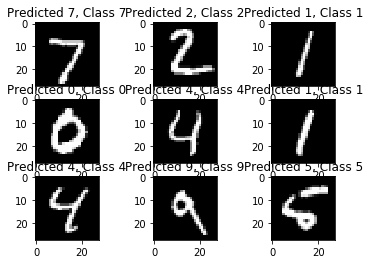

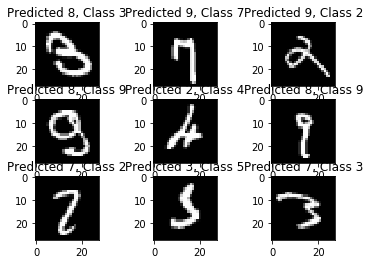

In [11]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Parte 2 - Usando uma rede neural convulacional

Vamos agora abordar o mesmo dataset, mas utilizando uma rede convolucional (CNN).

In [12]:
from keras.layers.core import Flatten
from keras.layers import Conv2D, MaxPooling2D

Usaremos a mesma base de dados do exemplo anterior, mas precisamos refazer nosso pré-processamento dos dados. Redes CNN operam com imagens como entrada, portanto não é necessário transformar as imagens em vetores. Imagens coloridas normalmente tem 3 canais (RGC), mas no caso do nosso dataset, as imagens estão em escala de cinza que só tem um canal.

Além disso, continuaremos alterando o range dos dados para [0-1]. Podemos fazer outros tipos de pre-processamento aqui, como normalização, corte de imagens, escala... mas não entraremos em maiores detalhes.

In [13]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

# 80% para treino e 20% para validação
nData = X_train.shape[0]
nTrain = int(nData * 0.8)

randomIdx = list(range(nData))   #randomly select indexes
shuffle(randomIdx)
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

# Split the data
X_val, y_val = X_train[valIdx], y_train[valIdx]
X_train, y_train = X_train[trainIdx], y_train[trainIdx]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)

img_rows, img_cols = 28, 28

#The first dimension refers to the number of images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, mnist_classes)
Y_val = np_utils.to_categorical(y_val, mnist_classes)
Y_test = np_utils.to_categorical(y_test, mnist_classes)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)
X_train shape (48000, 28, 28)
y_train shape (48000,)
X_val shape (12000, 28, 28)
y_val shape (12000,)
Training matrix shape (48000, 28, 28, 1)
Validation matrix shape (12000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


### Definindo nossa arquitetura

Vamos definir uma rede CNN simples com algumas camadas comuns nesse tipo de abordagem:

- Uma camada convolucional com 10 filtros de tamanho 5x5, com ativação *relu* (saída = 24x24x10)
- Uma camada de max pooling com kernel 2x2, que reduzirá as dimensões de cada imagem pela metade (saída = 12x12x10)
- Uma operação de flatten, que mapeará a imagem para um array (saída = 12x12x10 = 1440)
- Uma camada de dropout de 0.25
- Uma camada de saída completamente conectada com ativação softmax

In [14]:
# Define your model here
model = Sequential()
#Conv layer with 10 filters of size 5x5 and ReLU activation
model.add(Conv2D(10, kernel_size=(5, 5),
activation='relu', #ReLU activation
input_shape=(28, 28, 1))) #no need to include the batch size

#Max pooling of size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten operation
model.add(Flatten())

#Dropout with probability 0.25
model.add(Dropout(0.25))

#FC layer with 10 neurons and softmax activation
model.add(Dense(mnist_classes, activation='softmax'))

### Compilando o modelo

Vamos definir nossa função de perda e o otimizador para treinarmos nossa CNN. Nesse caso, vamos criar nosso próprio otimizador usando a função SGD. O otimizador SGD é uma variação do *Gradient Descent*, chamado *Stocastic Gradient Descent*. Ao invés de considerar todos os dados de treinamento para cada iteração do otimizador, SGD usa apenas uma amostra dos dados de treinamento de cada vez. Poderíamos ter passado o otimizador diretamente usando a string padrão 'sgd'.

In [15]:
sgd = optimizers.SGD(lr=0.01) #lr = learning rate
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### Treinando o modelo

In [16]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=3, verbose=1,
          validation_data=(X_val, Y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 5s 109us/step - loss: 1.2879 - accuracy: 0.6325 - val_loss: 0.5089 - val_accuracy: 0.8674
Epoch 2/3
48000/48000 [==============================] - 5s 106us/step - loss: 0.4924 - accuracy: 0.8554 - val_loss: 0.3786 - val_accuracy: 0.8953
Epoch 3/3
48000/48000 [==============================] - 5s 107us/step - loss: 0.4120 - accuracy: 0.8767 - val_loss: 0.3338 - val_accuracy: 0.9067


### Avaliando os resultados

In [17]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT NORMALIZED):', score[1])

10000/10000 [==============================] - 1s 69us/step
Test loss: 0.3097616092443466
Test accuracy (NOT NORMALIZED): 0.9165999889373779
